
# The $k$-Nearest Neighbor Classification Algorithm

    Notebook version: 2.3 (Sep 17, 2024)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            
    Changes: v.1.0 - First version
             v.1.1 - Function loadDataset updated to work with any number of dimensions
             v.2.0 - Compatible with Python 3 (backcompatible with Python 2.7)
                     Added solution to Exercise 3
             v.2.1 - Minor corrections regarding notation
             v.2.2 - Adaptation for slides conversion
             v.2.3 - (JCS) Removed implementation of knn from scratch. sklearn is used.
                     KNN and cross validation classes from sklearn are used.
                     Updated code.
             

In [1]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors

## 1. The binary classification problem.

In a binary classification problem, we are given an observation vector ${\bf x}\in \mathbb{R}^N$ which is known to belong to one and only one *category* or *class*, $y$, in the set ${\mathcal Y} = \{0, 1\}$. The goal of a classifier system is to predict the value of $y$ based on ${\bf x}$.

To design the classifier, we are given a collection of labelled observations ${\mathcal D} = \{({\bf x}_k, y_k)\}_{k=0}^{K-1}$ where, for each observation ${\bf x}_k$, the value of its true category, $y_k$, is known. All samples are outcomes of an unknown distribution $p_{{\bf X},Y}({\bf x}, y)$.

## 2. The Iris dataset

(Iris dataset presentation is based on this <a href=http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/> Tutorial </a> by <a href=http://machinelearningmastery.com/about/> Jason Brownlee</a>) 

To illustrate the algorithms, we will consider the <a href = http://archive.ics.uci.edu/ml/datasets/Iris> Iris dataset </a>, taken from the <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository </a>. Quoted from the dataset description:

> This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. [...] One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. 

The *class* is the species, which is one of *setosa*, *versicolor* or *virginica*. Each instance contains 4 measurements of given flowers: sepal length, sepal width, petal length and petal width, all in centimeters. 


In [2]:
df_data = pd.read_csv('datasets/iris.data', header=None)
df_data.head(10)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


We can inspect some basic statistics of the data features using the `describe` method from the `pandas` package.

In [3]:
df_data.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We will separate the features and the target categories into a feature matrix and a list of class labels. Labels will be mapped to integers to facilitate the treatment.

In [4]:
# Extract the features and the classes from the dataframe
X = df_data.iloc[:, 0:4].values
C = df_data.iloc[:, 4].values

# Map the classes to integers
Y = LabelEncoder().fit_transform(C)
# Get a dictionary mapping from integers to classes
int_to_class = dict(zip(Y, C))
# Get a dictionary mapping from classes to integers
class_to_int = dict(zip(C, Y))

n_clases = len(int_to_class)
n_samples, n_features = X.shape

# Show the data dimensions:
print(f"-- The feature matrix contains {n_samples} samples and {n_features} features.")

# Pretty print the mapping
print("-- The following mapping from integers to classes will be used:")
for k, v in int_to_class.items():
    print(f"     {k} -> {v}")

-- The feature matrix contains 150 samples and 4 features.
-- The following mapping from integers to classes will be used:
     0 -> Iris-setosa
     1 -> Iris-versicolor
     2 -> Iris-virginica


###  2.1. Training and validation

Next, we will split the data into two sets:

* **Training set**, that will be used to learn the classification model
* **Test set**, that will be used to evaluate the classification performance

To make the partition, we can use the `train_test_split` method from `sklearn`.

The code fragment below defines a function `loadDataset` that loads the data in a CSV with the provided filename, converts the flower measures (that were loaded as strings) into numbers and, finally, it splits the data into a training and test sets.

In [5]:
# Split the dataset into training and testing sets
X_trn_all, X_tst_all, Y_trn_all, Y_tst_all = train_test_split(
    X, Y, test_size=0.33, random_state=42)

# Dataset sizes
n_trn = len(Y_trn_all)
n_tst = len(Y_tst_all)

# Show the data dimensions:
print(f"-- {n_trn} training samples.")
print(f"-- {n_tst} test samples.")


-- 100 training samples.
-- 50 test samples.


### 2.2. Versicolor vs Virginica

In the following, we will design a classifier to separate classes "Versicolor" and "Virginica" using $x_0$ and $x_1$ only. To do so, we build a training set with samples from these categories, and a bynary label $y^{(k)} = 1$ for samples in class "Virginica", and $0$ for "Versicolor" data.

In [6]:
# Select two classes
ignored_class = 'Iris-setosa'
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'
# Select two features
ind = [0, 1]

# New map indices to classes
int_to_class_2 = {0: c0, 1: c1}
class_to_int_2 = {c0: 0, c1: 1}

# Select samples
X_trn = X_trn_all[Y_trn_all != class_to_int[ignored_class], :]
X_tst = X_tst_all[Y_tst_all != class_to_int[ignored_class], :]
# Select features
X_trn = X_trn[:, ind]
X_tst = X_tst[:, ind]

# Select labels for the selected features
Y_trn = Y_trn_all[Y_trn_all != class_to_int[ignored_class]]
Y_tst = Y_tst_all[Y_tst_all != class_to_int[ignored_class]]

# Map to new class indices
Y_trn = Y_trn == class_to_int[c1]
Y_tst = Y_tst == class_to_int[c1]

# Dataset sizes
n_trn = len(Y_trn)
n_tst = len(Y_tst)
# Show the data dimensions:
print(f"-- {n_trn} training samples.")
print(f"-- {n_tst} test samples.")

-- 69 training samples.
-- 31 test samples.


A scatter plot is useful to get some insights on the difficulty of the classification problem

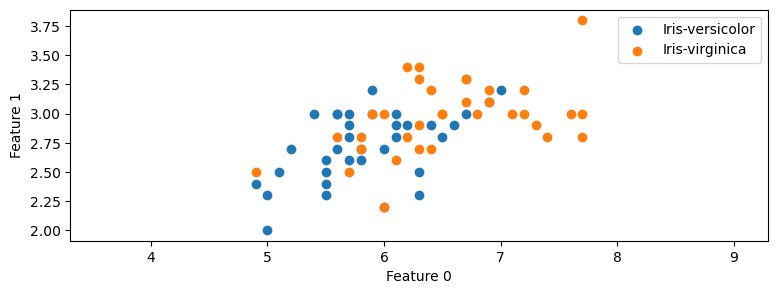

In [7]:
plt.figure(figsize=(9, 3))
for i in [0, 1]:
    # Plot the samples of class i
    plt.scatter(X_trn[Y_trn == i, 0], X_trn[Y_trn == i, 1],
                label=int_to_class_2[i])
plt.axis('equal')
plt.xlabel(f'Feature {ind[0]}')
plt.ylabel(f'Feature {ind[1]}')
plt.legend()
plt.show()

## 3. Baseline Classifier: Maximum A Priori.

For the selected data set, we have two clases and a dataset with the following class proportions:

In [8]:
print(f'Class 0 ({c0}): {n_trn - sum(Y_trn)} samples')
print(f'Class 1 ({c1}): {sum(Y_trn)} samples')

Class 0 (Iris-versicolor): 35 samples
Class 1 (Iris-virginica): 34 samples


The maximum a priori classifier assigns any sample ${\bf x}$ to the most frequent class in the training set. Therefore, the class prediction $y$ for any sample ${\bf x}$ is

In [9]:
y = int(2*sum(Y_trn) > n_trn)
print(f'y = {y} ({c1 if y==1 else c0})')

y = 0 (Iris-versicolor)


The error rate for this baseline classifier is:

In [10]:
# Training and test error arrays
E_trn = (Y_trn != y)
E_tst = (Y_tst != y)

# Error rates
pe_trn = float(sum(E_trn)) / n_trn
pe_tst = float(sum(E_tst)) / n_tst
print('Pe(train):', str(pe_trn))
print('Pe(test): ', str(pe_tst))

Pe(train): 0.4927536231884058
Pe(test):  0.5161290322580645


The error rate of the baseline classifier is a simple benchmark for classification. Since the maximum a priori decision is independent on the observation, ${\bf x}$, any classifier based on ${\bf x}$ should have a better (or, at least, not worse) performance than the baseline classifier.

## 4. The Nearest-Neighbour Classifier (1-NN).


The 1-NN classifier assigns any instance ${\bf x}$ to the category of the nearest neighbor in the training set.
$$
d = f({\bf x}) = y_n, {\rm~where} \\
n = \arg \min_k \|{\bf x}-{\bf x}_k\|
$$
In case of ties (i.e. if there is more than one instance at minimum distance) the class of one of them, taken arbitrarily, is assigned to ${\bf x}$.

Let us apply the 1-NN classifier to the given dataset. First, we will show the decision regions of the classifier. To do so, we compute the classifier output for all points in a rectangular grid from the sample space.

In [11]:
# Create a regtangular grid.
n_points = 200
x_min, x_max = X_trn[:, 0].min(), X_trn[:, 0].max() 
y_min, y_max = X_trn[:, 1].min(), X_trn[:, 1].max()
dx = x_max - x_min
dy = y_max - y_min
h = dy / n_points
xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                     np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
X_grid = np.array([xx.ravel(), yy.ravel()]).T



To apply the 1-NN classifier, we will use the `KNeigborsClassifier` class from `sklearn`.

In [12]:
# Create the classifier object
clf = neighbors.KNeighborsClassifier(1, weights='uniform')
# Train the classifier
clf.fit(X_trn, Y_trn)
# Predict the class of the samples in the grid
Z = clf.predict(X_grid)

Since the data are two-dimensional, we can visualize the decision boundary by coloring the grid according to the predicted class. The following code does this:

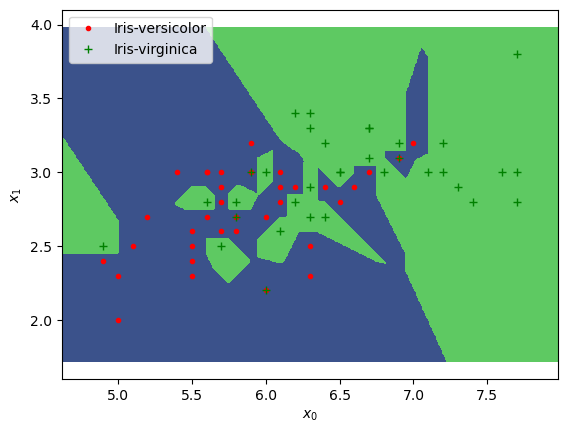

In [13]:
# Put the result into a color plot
plt.plot(X_trn[Y_trn==0, 0], X_trn[Y_trn==0, 1],'r.', label=c0)
plt.plot(X_trn[Y_trn==1, 0], X_trn[Y_trn==1, 1],'g+', label=c1)
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('equal')
plt.show()

We can observe that the decision boudary of the 1-NN classifier is rather intricate, and it may contain small *islands* covering one or few samples from one class. Actually, the extension of these small regions usually reduces as we have more training samples, though the number of them may increase.

Now we compute the error rates over the training and test sets.

In [14]:
# Predicions for the training and test inputs
Z_trn = clf.predict(X_trn)
Z_tst = clf.predict(X_tst)

# Error rates
pe_trn = np.mean(Z_trn != Y_trn)
pe_tst = np.mean(Z_tst != Y_tst)

print(f'Pe(train): {pe_trn:.4f}')
print(f'Pe(test):  {pe_tst:.4f}')

Pe(train): 0.0580
Pe(test):  0.4839


The training and test error rates of the 1-NN may be significantly different. In fact, the training error may go down to zero if samples do not overlap. In the selected problem, this is not the case, because samples from different classes coincide at the same point, causing some classification errors.

### 4.1. Consistency of the 1-NN classifier

Despite the 1-NN usually reduces the error rate with respect to the baseline classifier, the number of errors may be too large. Errors may be attributed to diferent causes:

   1. The class distributions are overlapped, because the selected features have no complete information for discriminating between the classes: this would imply that, even the best possible classifier would be prone to errors.
   2. The training sample is small, and it is not enough to obtaing a good estimate of the optimal classifiers.
   3. The classifier has intrinsic limitations: even though we had an infinite number of samples, the classifier performance does not approach the optimal classifiers.

In general, a classifier is said to be consistent if it makes nearly optimal decisions as the number of training samples increases. Actually, it can be shown that this is the case of the 1-NN classifier if the classification problem is separable, i.e. if there exist a decision boundary with zero error probability. Unfortunately, in a non-separable case, the 1-NN classifier is not consistent. It can be shown that the error rate of the 1-NN classifier converges to an error rate which is not worse than twice the minimum attainable error rate (Bayes error rate) as the number of training samples goes to infinity.

**Exercise 1**: In this exercise we test the non-consistency of the 1-NN classifier for overlapping distributions. Generate an artificial dataset for classification as follows:

- Generate $N$ binary labels at random with values '0' and '1'. Store them in vector ${\bf y}$
- For every label $y_k$ in ${\bf y}$:
    - If the label is 0, take sample $x_k$ at random from a uniform distribution $U(0,2)$.
    - If the label is 1, take sample $x_k$ at random from a uniform distribution $U(1,5)$.

Take $N=1000$ for the test set. This is a large sample to get accurate error rate estimates. Also, take $N=10$, $20$, $40$, $80$,... for the training set. Compute the 1-NN classifier, and observe the test error rate as a function of $N$. 

Now, compute the test error rate of the classifier making decision $1$ if $x_k>1.5$, and $0$ otherwise. 


In [15]:
# <SOL>
Ntest = 1000
Ntr = [10, 20, 40, 80, 200, 1000]
nruns = 100

xtest = []
ytest = []
for k in range(Ntest):
    yk = (k < Ntest / 2)
    ytest.append(yk)
    xtest.append([(1 - yk) + 2 * (2 - yk) * np.random.random()])

Etest = np.zeros((len(Ntr),))
for k in range(nruns):
    print(f"Run {k} out of {nruns}     \r", end="")
    for kk, Ntrain in enumerate(Ntr):
        xtrain = []
        ytrain = []
        for k in range(Ntrain):
            yk = (k < Ntrain / 2)
            ytrain.append(yk)
            xtrain.append([(1 - yk) + 2 * (2 - yk) * np.random.random()])

        # Train the classifier and get predictions for ytest
        clf = neighbors.KNeighborsClassifier(n_neighbors=1)
        ytest_pred = clf.fit(xtrain, ytrain).predict(xtest)
        error_rate = np.mean(np.array(ytest)!=ytest_pred)
        
        Etest[kk] += error_rate/nruns

print(Etest)
# </SOL>

[0.18157 0.17183 0.15944 0.15982 0.15506 0.15499]


## 5. $k$-NN classifier

A simple extension of the 1-NN classifier is the $k$-NN classifier, which, for any input sample ${\bf x}$, computes the $k$ closest neighbors in the training set, and takes the majority class in the subset. To avoid ties, in the binary classification case $k$ is usually taken as an odd number.

The following method implements the $k$-NN classifiers.

Now, we can plot the decision boundaries for different values of $k$

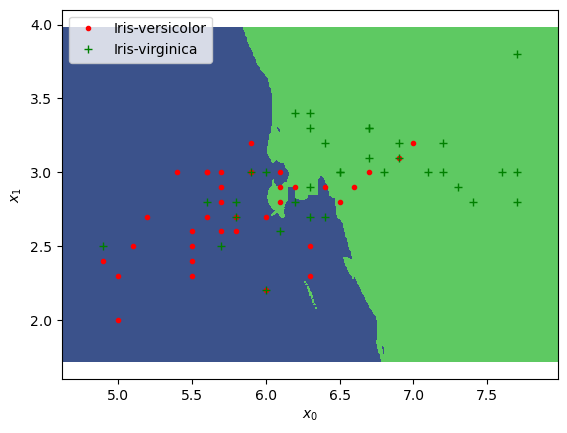

In [16]:
k = 15
# Create the classifier object
clf = neighbors.KNeighborsClassifier(k, weights='uniform')
# Train the classifier
clf.fit(X_trn, Y_trn)

# Compute the classifier output for all samples in the grid.
Z = clf.predict(X_grid)

# Put the result into a color plot
plt.plot(X_trn[Y_trn==0, 0], X_trn[Y_trn==0, 1],'r.', label=c0)
plt.plot(X_trn[Y_trn==1, 0], X_trn[Y_trn==1, 1],'g+', label=c1)
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('equal')
plt.show()

### 5.1. Influence of $k$

To find a good value of $k$, we can apply a validation procedure. Since the dataset is too small, we will use the test set as a validation set.

(Note that this implies that we will have no data to make a reliable evaluation of the final model performance)

In [17]:
# Plot training and validation error as a function of parameter k.
pe_trn = []
pe_val = []
k_list = [2*n+1 for n in range(int(np.floor(n_trn/2)))]

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(X_trn, Y_trn)

    # Training and test predictions
    Z_trn = clf.predict(X_trn)
    Z_val = clf.predict(X_tst)

    # Error rates
    pe_trn.append(np.mean(Z_trn != Y_trn))
    pe_val.append(np.mean(Z_val != Y_tst))

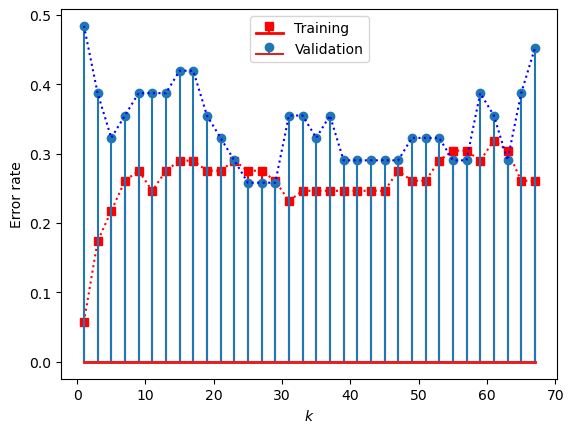

In [18]:
# Draw the result into a color plot
markerline, stemlines, baseline = plt.stem(k_list, pe_trn, 'r', markerfmt='s', label='Training')
plt.plot(k_list, pe_trn,'r:')
plt.setp(markerline, 'markerfacecolor', 'r', )
plt.setp(baseline, 'color','r', 'linewidth', 2)

markerline, stemlines, baseline = plt.stem(k_list, pe_val, label='Validation')
plt.plot(k_list, pe_val,'b:')
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.legend(loc='best')
plt.show()

**Exercise 2**: Observe the train and test error for large $k$. Could you relate the error rate of the baseline classifier with that to the $k$-NN for certain value of $k$? 

The figure above suggests that the optimal value of $k$ is

In [19]:
i = np.argmin(pe_val)
k_opt = k_list[i]
print('k_opt:', k_opt)

k_opt: 25


However, using the test set to select the optimal value of the hyperparameter $k$ is not allowed. Instead, we should recur to cross validation.

### 5.2 Hyperparameter selection via cross-validation

Since using the test labels during the training phase is not recommended (they should be kept aside to simultate the future application of the classification model on unseen patterns), we need to figure out some way to improve our estimation of the hyperparameter that requires only training data. Cross-validation allows us to do so by following the following steps:

   1. **Split the training data** into several (generally non-overlapping) subsets. If we use $M$ subsets, the method is referred to as $M$-fold cross-validation. If we consider each pattern a different subset, the method is usually referred to as leave-one-out (LOO) cross-validation.
   2. **Train** of the system $M$ times. For each run, use a different partition as a *validation* set, and use the restating partitions as the training set. **Evaluate** the performance for different choices of the hyperparameter (i.e., for different values of $k$ for the $k$-NN method).
   3. **Average the validation error** over all partitions, and pick the hyperparameter that provided the minimum validation error.
   4. **Rerun** the algorithm using all the training data, keeping the value of the parameter that came out of the cross-validation process.

In [20]:
# Parameters:
k_max = 20  # Maximum value of the k-nn hyperparameter to explore
n_splits = 5  # Number of folds in the cross-validation
# List of all odd integers from 1 to k_max
k_list = [2 * j + 1 for j in range(k_max // 2)]

# Now we create the KFold object with 5 folds
kf = KFold(n_splits=n_splits)

# Obtain the validation errors for each fold
pe_trn = np.zeros((len(k_list)))
pe_val = np.zeros((len(k_list)))
for i, (trn_index, val_index) in enumerate(kf.split(X_trn, Y_trn)):
    print(f"Fold {i}:  \r", end="", flush=True)

    # Compute the Pe, for this fold, for each k
    for i, k in enumerate(k_list):
        clfk = neighbors.KNeighborsClassifier(k, weights='uniform')
        clfk.fit(X_trn[trn_index, :], Y_trn[trn_index])
        pe_trn[i] += np.mean(Y_trn[trn_index] != clfk.predict(X_trn[trn_index, :])) 
        pe_val[i] += np.mean(Y_trn[val_index] != clfk.predict(X_trn[val_index, :]))

pe_trn = pe_trn / n_splits
pe_val = pe_val / n_splits

# Select the best k based on the validation error
i_best = np.argmin(pe_val) + 1
k_best = k_list[i_best]
print(f'-- Best value of k: {k_best}')


-- Best value of k: 13


10
10
0.3870967741935484


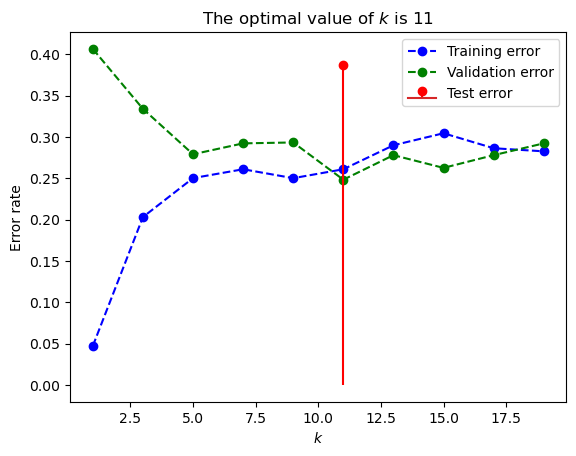

In [21]:
# We compute now the train and test errors curves
k_opt = k_list[np.argmin(pe_val)]

# Train the classifier and get predictions for ytest
clf = neighbors.KNeighborsClassifier(k_opt, weights='uniform')
clf.fit(X_trn, Y_trn)  
pe_tst = np.mean(Y_tst != clf.predict(X_tst))

print(len(pe_trn))
print(len(k_list))
print(pe_tst)

plt.plot(k_list, pe_trn,'b--o',label='Training error')
plt.plot(k_list, pe_val.T,'g--o',label='Validation error')
plt.stem([k_opt], [pe_tst],'r-o',label='Test error')
plt.legend(loc='best')
plt.title('The optimal value of $k$ is ' + str(k_opt))
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.show()

### Cross validation using cross_val_score

Note that there is a simple way to apply cross validation withouth looping explicitely over the data particions. This is done internally by the `cross_val_score` methods, that returns the scores for all elements in the partition.

The scoring method can be introduced as a parameter. We can use the accuracy, which is the opposite of the error rate.

In [22]:
# Parameters:
k_max = 20  # Maximum value of the k-nn hyperparameter to explore
n_splits = 5  # Number of folds in the cross-validation

# List of all odd integers from 1 to k_max
k_list = [2 * j + 1 for j in range(k_max // 2)]

# Obtain the validation errors for each fold
pe_val = np.zeros((len(k_list)))

# Compute the Pe, for this fold, for each k
for i, k in enumerate(k_list):
    clfk = neighbors.KNeighborsClassifier(k, weights='uniform')
    scores = cross_val_score(clfk, X_trn, Y_trn, cv=n_splits, scoring='accuracy')
    pe_val[i] = 1 - np.mean(scores)

# Select the best k based on the validation error
i_best = np.argmin(pe_val) + 1
k_best = k_list[i_best]
print(f'-- Best value of k: {k_best}')


-- Best value of k: 13


<a href = http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html> Here</a> you can find an example of the application of `KNeighborsClassifier` to the complete 3-class Iris flower classification problem.

## 6. $k$-NN Classification and Probability Estimation.

If a sample ${\bf x}$ has $m$ neighbors from class 1 and $k-m$ neighbors from class $0$, we can estimate the **posterior probability** that an observation ${\bf x}$ belongs to class 1 as
$$
\hat P\{y=1|x\} = \frac{m}{k}
$$
Therefore, besides computing a decision about the class of the data, we can modify the $k$-NN algorithm to obtain posterior probability estimates.

Note that the above equation is equivalent to
$$
\hat P\{y=1|x\} = \frac{\sum_{n \in {\mathcal N}({\bf x})} y^{(n)}}{k}
$$
where ${\mathcal N}({\bf x})$ is the set of indices for the samples in the neighborhood of $\bf x$.

In other words, $\hat P\{y=1|x\}$ is the *average* of the neighbor labels. This is actually what the $k$-NN regression algorithm does. Thus, we can estimate the posterior using the `sklearn` regression methods from `KNeighborsRegressor`.


**Exercise 3**: Plot a $k$-NN posterior probability map for the Iris flower data, for $k=15$.

In [23]:
#<SOL>
k = 15
neigh = neighbors.KNeighborsRegressor(n_neighbors=k)
Z = neigh.fit(X_trn, Y_trn).predict(X_grid)

#</SOL>

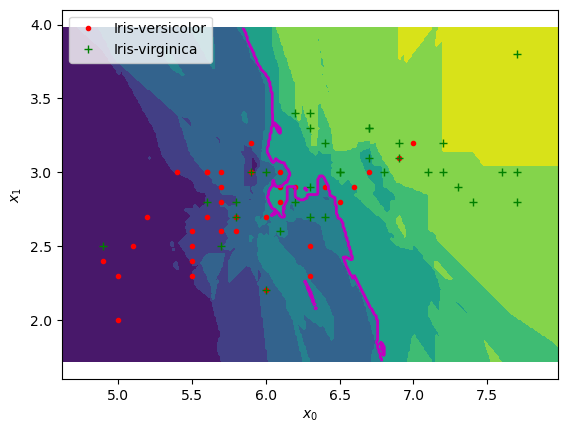

In [24]:
#<SOL>
# Put the result into a color plot
plt.plot(X_trn[Y_trn==0, 0], X_trn[Y_trn==0, 1],'r.', label=c0)
plt.plot(X_trn[Y_trn==1, 0], X_trn[Y_trn==1, 1],'g+', label=c1)
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
#plt.contourf(xx, yy, Z)
CS = plt.contourf(xx, yy, Z)
CS2 = plt.contour(CS, levels=[0.5], colors='m', linewidths=(2,))
plt.axis('equal')
plt.show()

#</SOL>